In [ ]:
pip install insightface

In [ ]:
!pip install onnxruntime


In [ ]:
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt

import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

In [ ]:
app = FaceAnalysis(name= 'buffalo_l')
app.prepare(ctx_id=0, det_size=(640, 640))

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


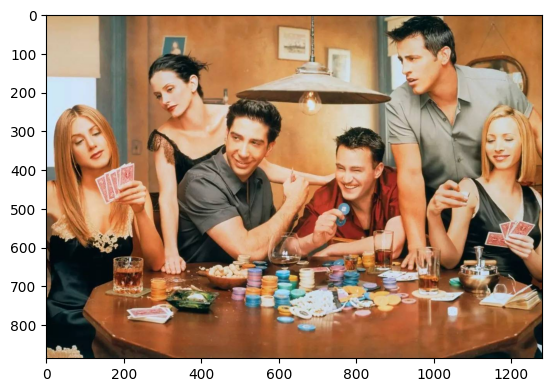

In [ ]:
img = ins_get_image('t1')
plt.imshow(img[:,:,::-1])
plt.show()

In [ ]:
faces = app.get(img)

/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


In [ ]:
len(faces)

6

In [ ]:
faces[0].keys()

dict_keys(['bbox', 'kps', 'det_score', 'landmark_3d_68', 'pose', 'landmark_2d_106', 'gender', 'age', 'embedding'])

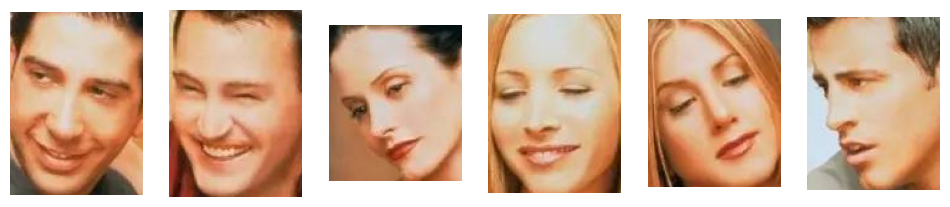

In [ ]:
img = ins_get_image('t1')
fig, axs = plt.subplots(1, 6, figsize=(12, 5))

for i, face in enumerate(faces):
    bbox = face['bbox']
    bbox = [int(b) for b in bbox]
    axs[i].imshow(img[bbox[1]:bbox[3], bbox[0]:bbox[2], ::-1])
    axs[i].axis('off')


In [ ]:
swapper = insightface.model_zoo.get_model('/content/inswapper_128.onnx',
                                          download = False,
                                          download_zip = False)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
inswapper-shape: [1, 3, 128, 128]


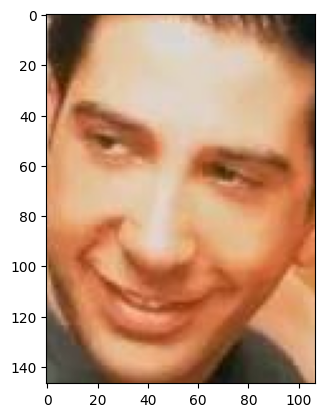

In [ ]:
source_face = faces[0]
bbox = source_face['bbox']
bbox = [int(b) for b in bbox]
plt.imshow(img[bbox[1]:bbox[3], bbox[0]:bbox[2], ::-1])
plt.show()


In [ ]:
res = img.copy()
for face in faces:
    res = swapper.get(res, face, source_face, paste_back=True)


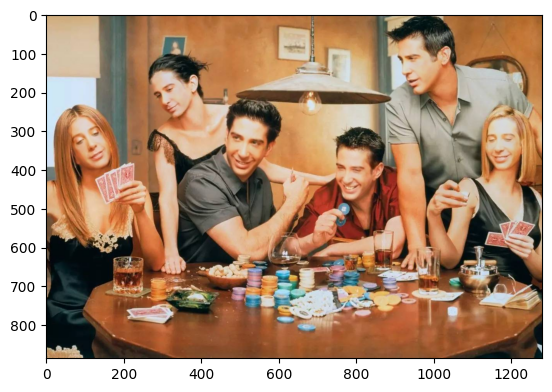

In [ ]:
# Plot the Swapped Faces
plt.imshow(res[:, :, ::-1])
plt.show()


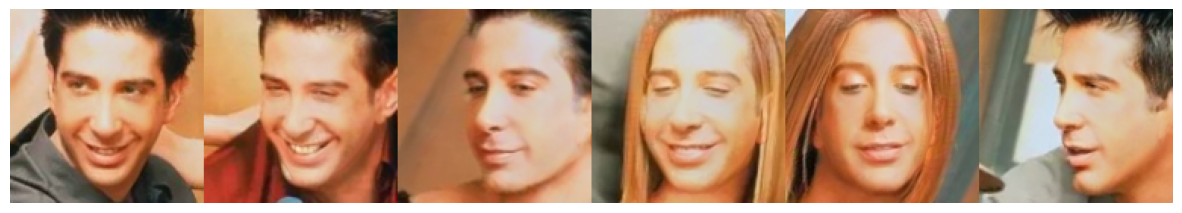

In [ ]:
res = []
for face in faces:
    _img, _ = swapper.get(img, face, source_face, paste_back=False)
    res.append(_img)

res = np.concatenate(res, axis=1)
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(res[:, :, ::-1])
ax.axis('off')
plt.show()


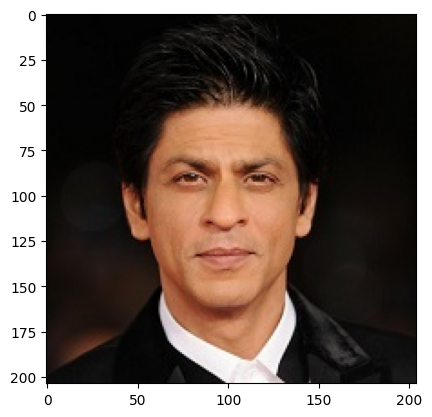

In [ ]:
rob = cv2.imread('/content/shah-rukh-khan-2092-12-09-2017-02-10-43-1541034887.jpg')
plt.imshow(rob[:, :, ::-1])
plt.show()

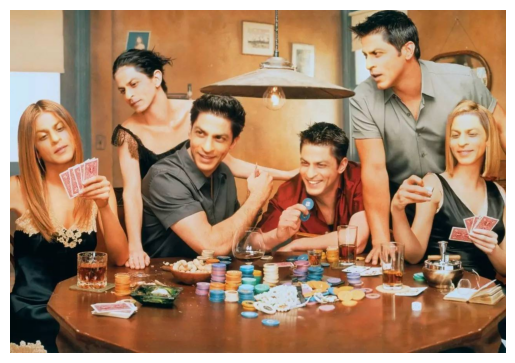

In [ ]:
# Detect the Face
rob_faces = app.get(rob)
rob_face = rob_faces[0]
# Replace faces in friend's image
res = img.copy()
for face in faces:
    res = swapper.get(res, face, rob_face, paste_back=True)

fig, ax = plt.subplots()
ax.imshow(res[:, :, ::-1])
ax.axis('off')
plt.show()


# Swap faces

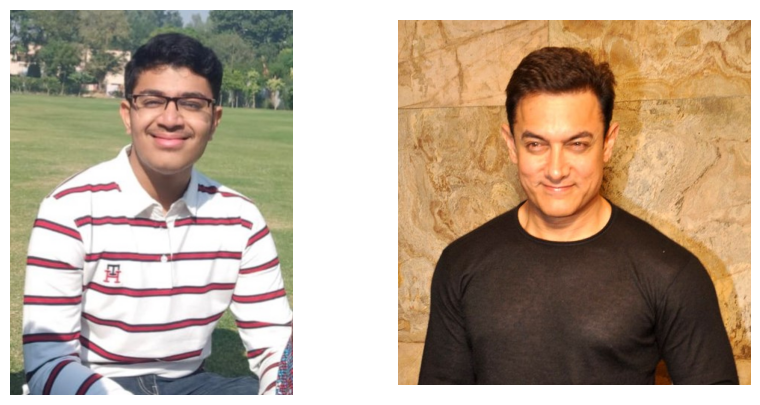

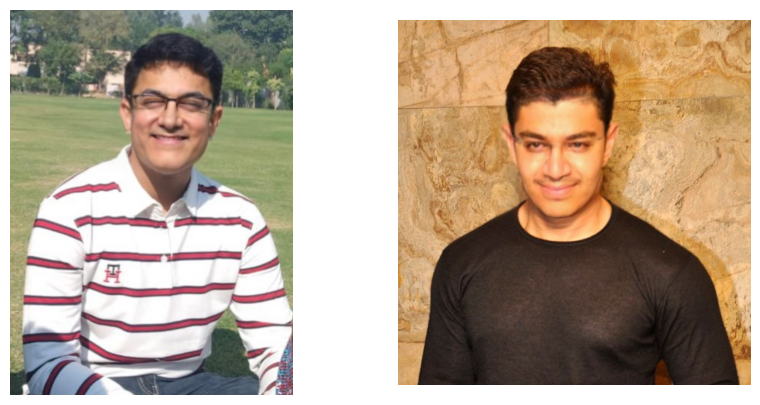

In [ ]:
import cv2
import matplotlib.pyplot as plt

def swap_n_show(img1_fn,
                img2_fn,  # Corrected parameter name
                app,
                swapper,
                plot_before=True,
                plot_after=True):
    img1 = cv2.imread(img1_fn)
    img2 = cv2.imread(img2_fn)

    if plot_before:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(img1[:, :, ::-1])
        axs[0].axis('off')
        axs[1].imshow(img2[:, :, ::-1])
        axs[1].axis('off')
        plt.show()

    face1 = app.get(img1)[0]
    face2 = app.get(img2)[0]

    img1_ = img1.copy()
    img2_ = img2.copy()

    if plot_after:
        img1_ = swapper.get(img1_, face1, face2, paste_back=True)
        img2_ = swapper.get(img2_, face2, face1, paste_back=True)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(img1_[:, :, ::-1])
        axs[0].axis('off')
        axs[1].imshow(img2_[:, :, ::-1])
        axs[1].axis('off')
        plt.show()

    return img1_, img2_

# Call the function with the correct parameter names
_ = swap_n_show('/content/lakshya.jpg',
            '/content/Aamir_Khan.jpg',
            app,
            swapper)


# Swap in same image

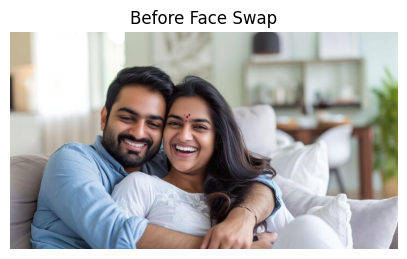

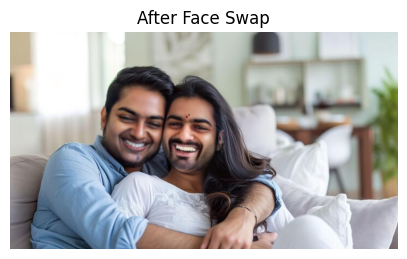

In [ ]:
import cv2
import matplotlib.pyplot as plt

def swap_in_image(img_fn, app, swapper, plot_before=True, plot_after=True):
    img = cv2.imread(img_fn)

    if plot_before:
        plt.figure(figsize=(5, 5))
        plt.imshow(img[:, :, ::-1])
        plt.axis('off')
        plt.title("Before Face Swap")
        plt.show()

    # Detect faces in the image
    faces = app.get(img)

    # Ensure at least two faces are detected for swapping
    if len(faces) < 2:
        print("Less than two faces detected. Cannot perform swapping.")
        return img

    # Copy the original image to avoid modifying it
    img_ = img.copy()

    # Swap faces pairwise
    for i in range(len(faces) - 1):
        face1 = faces[i]
        face2 = faces[i + 1]
        img_ = swapper.get(img_, face1, face2, paste_back=True)
        img_ = swapper.get(img_, face2, face1, paste_back=True)

    if plot_after:
        plt.figure(figsize=(5, 5))
        plt.imshow(img_[:, :, ::-1])
        plt.axis('off')
        plt.title("After Face Swap")
        plt.show()

    return img_

# Call the function with a single image
_ = swap_in_image('/content/ai-generated-celebrating-parenthood-happy-indian-couple-embracing-at-home-photo.jpg', app, swapper)


# video swap

In [ ]:
import cv2
import os


def video_to_frames(video_path, output_folder, interval=1):
    # Check if the output folder exists, if not, create it
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Load the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Get the frames per second (fps) of the video
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = 0
    sec_count = 0

    while True:
        # Set the position of the video in milliseconds
        cap.set(cv2.CAP_PROP_POS_MSEC, sec_count * 1000)

        # Read a frame from the video
        ret, frame = cap.read()

        # If the frame was not retrieved successfully, we're at the end of the video
        if not ret:
            break

        # Create the filename and save the frame as an image
        frame_filename = os.path.join(output_folder, f"frame_{frame_count:05d}.jpg")
        cv2.imwrite(frame_filename, frame)

        frame_count += 1
        sec_count += interval

    cap.release()
    print(f"Extracted {frame_count} frames from the video.")


# Example usage:
video_path = '/content/vid5.mp4'
output_folder = 'vid5_images'
video_to_frames(video_path, output_folder)

Extracted 3 frames from the video.


Processing: /content/vid4_images/frame_00000.jpg and /content/vid5_images/frame_00000.jpg


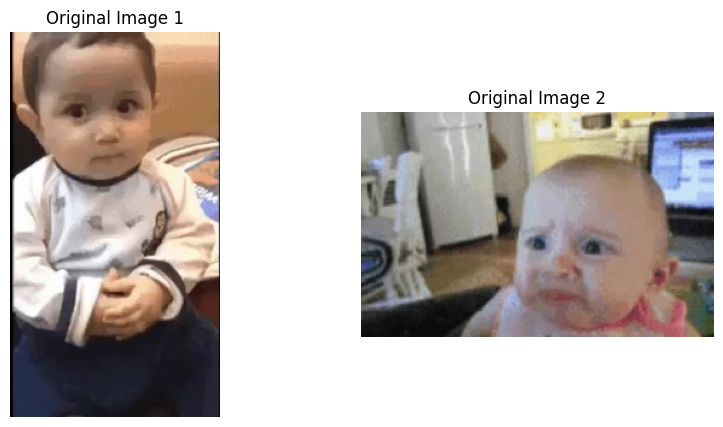

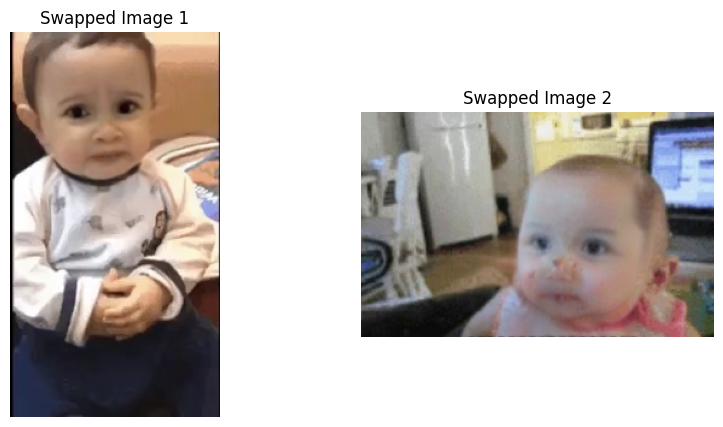

Saved swapped images to: output_dir1/swapped_frame_00000.jpg and output_dir2/swapped_frame_00000.jpg
Processing: /content/vid4_images/frame_00001.jpg and /content/vid5_images/frame_00001.jpg


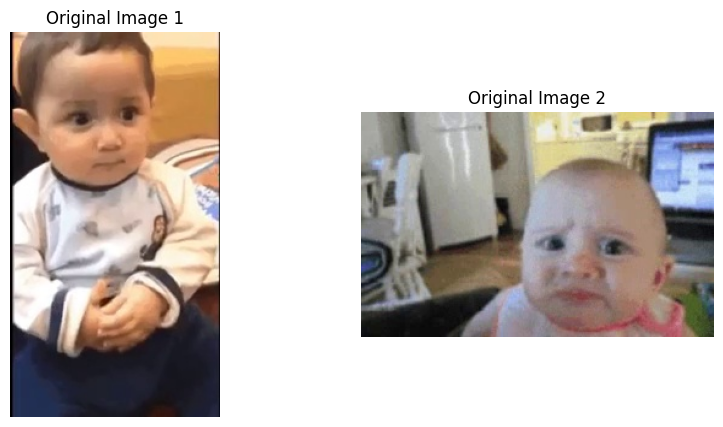

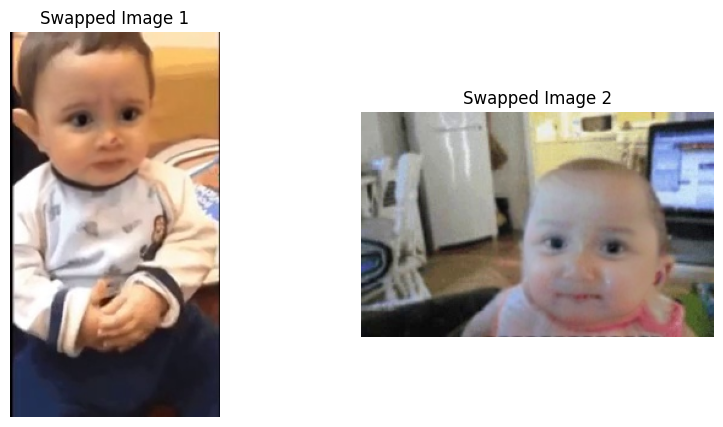

Saved swapped images to: output_dir1/swapped_frame_00001.jpg and output_dir2/swapped_frame_00001.jpg
Video saved as output_dir1/swap_video.avi


In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

def swap_n_show_directory(dir1, dir2, app, swapper, output_dir1='output_dir1', output_dir2='output_dir2',
                          plot_before=True, plot_after=True):
    """
    This function takes two directories, detects faces in images from each directory using the provided 'app' object,
    swaps the detected faces using the 'swapper' object, displays the images before and after swapping, saves the
    swapped images to specified output directories, and creates a video from the output frames.

    Parameters:
    - dir1: str, path to the first directory containing images.
    - dir2: str, path to the second directory containing images.
    - app: object, a face detection object that has a 'get' method to detect faces in an image.
    - swapper: object, a face swapping object that has a 'get' method to swap faces between images.
    - output_dir1: str, path to the output directory for images swapped from the first set.
    - output_dir2: str, path to the output directory for images swapped from the second set.
    - plot_before: bool, if True, plots the original images before swapping.
    - plot_after: bool, if True, plots the images after face swapping.
    """

    # Create output directories if they do not exist
    os.makedirs(output_dir1, exist_ok=True)
    os.makedirs(output_dir2, exist_ok=True)

    # Create a video output path based on the output directory names
    video_output = os.path.join(output_dir1, 'swap_video.avi')

    # List all files in the directories
    img1_files = sorted([os.path.join(dir1, f) for f in os.listdir(dir1) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    img2_files = sorted([os.path.join(dir2, f) for f in os.listdir(dir2) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    # Ensure both directories have the same number of images for processing in pairs
    if len(img1_files) != len(img2_files):
        print(f"Error: Number of images in {dir1} ({len(img1_files)}) and {dir2} ({len(img2_files)}) do not match.")
        return

    # Initialize VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Define the codec
    frame_rate = 10                           # Frames per second
    video_writer = None                       # Placeholder for video writer

    for img1_fn, img2_fn in zip(img1_files, img2_files):
        print(f"Processing: {img1_fn} and {img2_fn}")

        # Read the images
        img1 = cv2.imread(img1_fn)
        img2 = cv2.imread(img2_fn)

        # Check if images are loaded properly
        if img1 is None or img2 is None:
            print(f"Error: Failed to load image from '{img1_fn}' or '{img2_fn}'.")
            continue

        # Display original images if plot_before is True
        if plot_before:
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            axs[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
            axs[0].axis('off')
            axs[0].set_title('Original Image 1')
            axs[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
            axs[1].axis('off')
            axs[1].set_title('Original Image 2')
            plt.show()

        # Detect faces in both images using the app object
        faces1 = app.get(img1)
        faces2 = app.get(img2)

        if not faces1 or not faces2:
            print(f"No faces detected in one or both images. Skipping...")
            continue

        face1 = faces1[0]
        face2 = faces2[0]

        img1_ = img1.copy()
        img2_ = img2.copy()

        if plot_after:
            img1_ = swapper.get(img1_, face1, face2, paste_back=True)
            img2_ = swapper.get(img2_, face2, face1, paste_back=True)

            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            axs[0].imshow(cv2.cvtColor(img1_, cv2.COLOR_BGR2RGB))
            axs[0].axis('off')
            axs[0].set_title('Swapped Image 1')
            axs[1].imshow(cv2.cvtColor(img2_, cv2.COLOR_BGR2RGB))
            axs[1].axis('off')
            axs[1].set_title('Swapped Image 2')
            plt.show()

        # Save the swapped images
        base_name1 = os.path.basename(img1_fn)
        base_name2 = os.path.basename(img2_fn)
        output_img1_fn = os.path.join(output_dir1, f"swapped_{base_name1}")
        output_img2_fn = os.path.join(output_dir2, f"swapped_{base_name2}")
        cv2.imwrite(output_img1_fn, img1_)
        cv2.imwrite(output_img2_fn, img2_)
        print(f"Saved swapped images to: {output_img1_fn} and {output_img2_fn}")

        # Initialize the VideoWriter if not done already, using the size of the first image
        if video_writer is None:
            height, width, _ = img1_.shape
            video_writer = cv2.VideoWriter(video_output, fourcc, frame_rate, (width, height))

        # Add the swapped images to the video
        video_writer.write(img1_)
        video_writer.write(img2_)

    # Release the VideoWriter object
    if video_writer is not None:
        video_writer.release()
        print(f"Video saved as {video_output}")

# Example usage of the function with directories containing images
swap_n_show_directory('/content/vid4_images', '/content/vid5_images', app, swapper)


In [ ]:
!ffmpeg -i /content/output_dir1/swap_video.avi /content/output_dir1/swap_video.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Video saved as /content/output_dir1/output_video.mp4


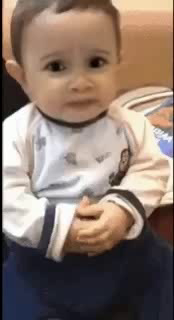

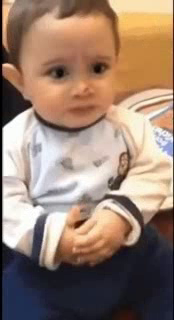

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow

def images_to_video(image_dir, video_path, fps=5):
    """
    Converts a sequence of images in a directory into a video.

    Parameters:
    - image_dir: str, the directory containing image files.
    - video_path: str, the output path for the generated video file.
    - fps: int, frames per second for the video.
    """
    # Get a list of all image files in the directory
    images = sorted([img for img in os.listdir(image_dir) if img.endswith((".png", ".jpg", ".jpeg"))])

    # Check if there are images in the directory
    if not images:
        print(f"No images found in the directory {image_dir}")
        return

    # Read the first image to get the dimensions
    first_image = cv2.imread(os.path.join(image_dir, images[0]))
    height, width, layers = first_image.shape

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can use other codecs like 'MJPG', 'MP4V', etc.
    video = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

    for image in images:
        img_path = os.path.join(image_dir, image)
        img = cv2.imread(img_path)
        video.write(img)

    # Release the video writer
    video.release()
    print(f"Video saved as {video_path}")

def play_video(video_path):
    """
    Plays the video from the given path in Google Colab.

    Parameters:
    - video_path: str, path to the video file.
    """
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        cv2_imshow(frame)

        # Pause briefly between frames (25 milliseconds)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    cap.release()

# Example usage
image_dir = '/content/output_dir1'  # Directory where your images are stored
video_path = '/content/output_dir1/output_video.mp4'  # Path to save the generated video

# Convert images to video
images_to_video(image_dir, video_path, fps=5)

# Play the created video
play_video(video_path)
